In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=24).mean()
    rolstd = timeseries.rolling(center=False,window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


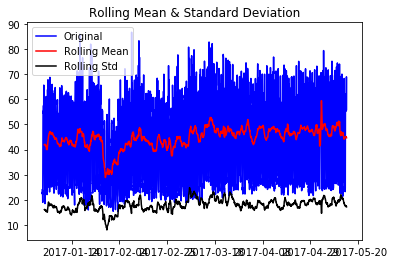

Results of Dickey-Fuller Test:
Test Statistic                   -4.164275
p-value                           0.000757
Lags Used                        25.000000
Number of Observations Used    3161.000000
Critical Value (5%)              -2.862455
Critical Value (1%)              -3.432420
Critical Value (10%)             -2.567257
dtype: float64


In [17]:
from pandas import Series
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
series = pd.to_numeric(series,errors='coerce')
series = series.dropna(axis=0)
test_stationarity(series)

Test Statistic                   -4.395312
p-value                           0.000303
Lags Used                        27.000000
Number of Observations Used    2794.000000
Critical Value (5%)              -2.862575
Critical Value (1%)              -3.432693
Critical Value (10%)             -2.567321
dtype: float64


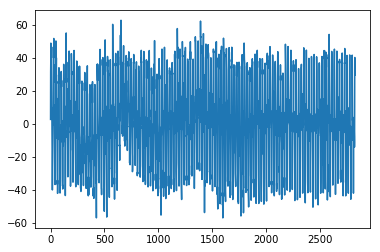

In [18]:
import pandas as pd
import numpy
X = series.values
# 用差分消除季节性差异
%matplotlib inline
import matplotlib.pyplot as plt
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
hours_in_day = 24
#days_in_year = 365
differenced = difference(X, days_in_year)
# differenced = numpy.diff(X)
# differenced = numpy.diff(differenced)
# temp = numpy.array(differenced)[1:] # 差分后第一个值为NaN,舍去
# t = sm.tsa.stattools.adfuller(temp)  # ADF检验
# print("p-value:   " + str(t[1]))
# print(differenced)
# differenced.plot()
# pyplot.show()
plt.plot(differenced)
# test_stationarity(differenced)
dftest = adfuller(differenced, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [19]:
# 训练集与测试集的切分
split_point = len(series) - 24
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 3163, Validation 24


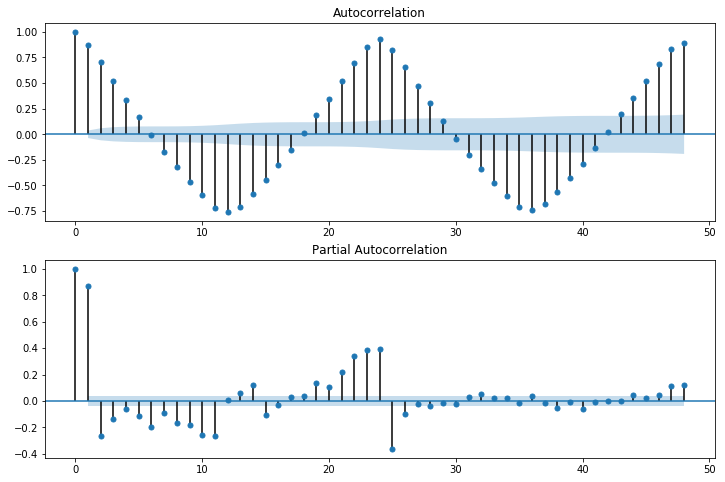

In [20]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(differenced,lags=48,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced,lags=48,ax=ax2)

In [21]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [22]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

# load dataset
series = Series.from_csv('dataset.csv', header=None)
# seasonal difference
X = series.values
hours_in_day = 24
differenced = difference(X, hours_in_day)
# fit model
model = ARIMA(differenced, order=(6,0,2))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

F:\anaconda\envs\individual-project\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3139
Model:                     ARMA(6, 2)   Log Likelihood               -9909.382
Method:                       css-mle   S.D. of innovations              5.683
Date:                Sun, 23 Jul 2017   AIC                          19838.765
Time:                        16:57:47   BIC                          19899.281
Sample:                             0   HQIC                         19860.482
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.259      0.043      0.965      -0.497       0.519
ar.L1.y        0.5018      0.018     27.547      0.000       0.466       0.538
ar.L2.y       -0.8816      0.020    -43.965      0.0

In [23]:
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, hours_in_day)
print('Forecast: %f' % forecast)

Forecast: 39.508575


In [24]:
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=24)[0]
# invert the differenced forecast 
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, hours_in_day)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 39.508575
Day 2: 24.446332
Day 3: 22.463588
Day 4: 21.632451
Day 5: 23.916239
Day 6: 25.608688
Day 7: 21.991451
Day 8: 23.643849
Day 9: 21.133685
Day 10: 22.474171
Day 11: 23.261875
Day 12: 51.094425
Day 13: 58.897502
Day 14: 60.839711
Day 15: 57.834784
Day 16: 58.440235
Day 17: 60.841376
Day 18: 57.756785
Day 19: 58.814302
Day 20: 58.023767
Day 21: 58.396049
Day 22: 67.991802
Day 23: 68.752451
Day 24: 61.709364


In [25]:
print(validation)

2017-01-01 00:16:24
2017-05-13 21:37:14    46.919998
2017-05-13 22:37:23    27.080000
2017-05-13 23:37:53    27.440001
2017-05-14 00:37:58    27.040001
2017-05-14 01:38:04    23.719999
2017-05-14 02:38:23    25.160000
2017-05-14 03:38:23    26.440001
2017-05-14 04:39:50    25.559999
2017-05-14 05:40:29    23.360001
2017-05-14 06:40:37    23.280001
2017-05-14 07:40:51    24.799999
2017-05-14 08:40:57    51.000000
2017-05-14 09:42:02    60.560001
2017-05-14 10:42:08    62.040001
2017-05-14 11:42:53    59.200001
2017-05-14 12:43:00    55.200001
2017-05-14 13:43:14    56.880001
2017-05-14 14:43:28    58.919998
2017-05-14 15:43:29    62.000000
2017-05-14 16:43:51    57.240002
2017-05-14 17:44:19    55.520000
2017-05-14 18:44:23    68.160004
2017-05-14 19:44:44    68.879997
2017-05-14 20:44:50    55.840000
Name: 24.92, dtype: float64


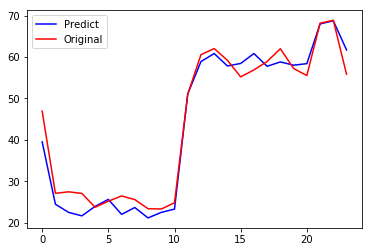

In [26]:
pre7 = plt.plot(history[-24:], color='blue',label='Predict')
ori7 = plt.plot(validation.tolist(), color='red', label='Original')
plt.legend(loc='best')
plt.show(block=False)